## Project: Finding Donors for *CharityML*

In this project, we will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. We can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
The cell below loads necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000.

In [18]:
# Total number of records
all_counts = data['income'].value_counts()
n_records = all_counts['<=50K'] + all_counts['>50K']

# Number of records where individual's income is more than $50,000
n_greater_50k = all_counts['>50K']

# Number of records where individual's income is at most $50,000
n_at_most_50k = all_counts['<=50K']

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k/n_records*100

# Print the results
print("Total number of records: {:,}".format(n_records))
print("Individuals making more than $50,000: {:,}".format(n_greater_50k))
print("Individuals making at most $50,000: {:,}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45,222
Individuals making more than $50,000: 11,208
Individuals making at most $50,000: 34,014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: Continuous. 
* **workclass**: Categorical - Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Categorical - Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: Continuous. 
* **marital-status**: Categorical - Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Categorical - Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Categorical - Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Categorical - Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Categorical - Female, Male. 
* **capital-gain**: Continuous. 
* **capital-loss**: Continuous. 
* **hours-per-week**: Continuous. 
* **native-country**: Categorical - United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`.

C:\Users\shahzeb.akhtar\Documents\GitHub\Finiding_Donors\visuals.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


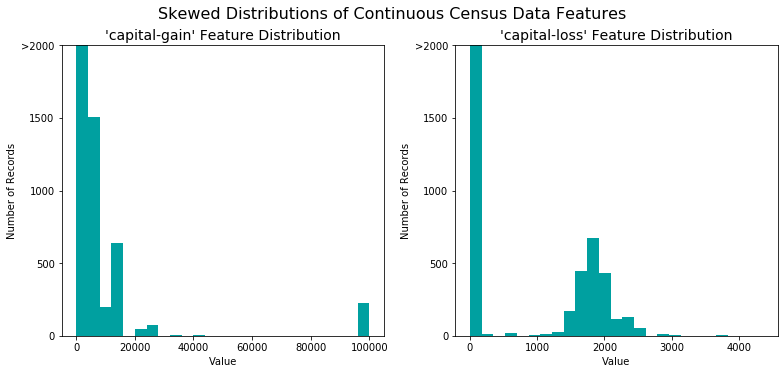

In [6]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully. 

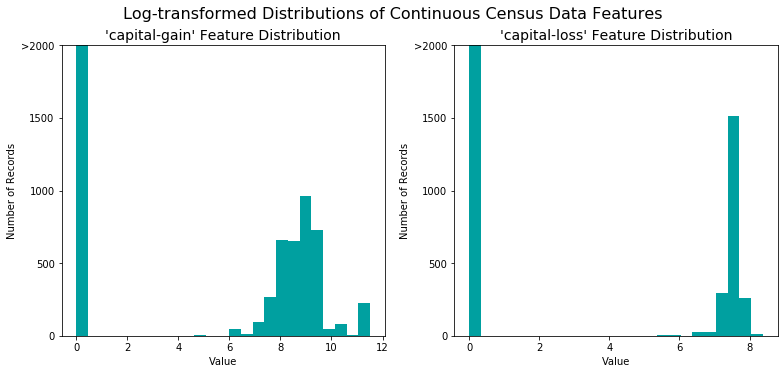

In [7]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning.

In [8]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing

In [9]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K':0, '>50K':1})


# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

print (encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. We will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [11]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {:,} samples.".format(X_train.shape[0]))
print("Testing set has {:,} samples.".format(X_test.shape[0]))

Training set has 36,177 samples.
Testing set has 9,045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000 and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for our data, to help establish a benchmark for whether a model is performing well.

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

### Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset?

In [12]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
#encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = (TP + TN)/(TP + TN + FP + FN)
recall = TP/(TP + FN)
precision = TP/(TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5*0.5)*(precision*recall)/((0.5*0.5*precision) + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Model Application
Below are three supervised learning models that are appropriate for this problem that we will test on the census data.

**Gaussian Naive Bayes (GaussianNB)**

*One real-world application in industry where the model can be applied:*

Classifying documents. For example – spam or legitimate emails

*Strengths of the model; when it performs well:*
-	Easy to implement
-	Scale with dataset
-	Performs well when features are mostly independent
-	Fast and efficient

*Weaknesses of the model; when it performs poorly:*
- One of the assumptions of Naive Bayes is independence of features, so if features are heavily correlated, it will not perform well

*What makes this model a good candidate for the problem:*
-	100+ features
-	40k+ data set
-	As NB is fast and efficient, it is one of my choice

References
-	https://www.youtube.com/watch?v=nfbKTrufPOs
-	https://www.youtube.com/watch?v=CPqOCI0ahss


**Decision Tree**

*One real-world application in industry where the model can be applied:*
-	Determine price of home based on number of rooms, area, etc.

*Strengths of the model; when it performs well:*
-	Easy to use
-	Easy to interpret data
-	Good for feature selection
-	Can handle numerical as well as categorical data

*Weaknesses of the model; when it performs poorly:*
-	Prone to over-fitting, for high number of features

*What makes this model a good candidate for the problem:*
-	Data has both numerical as well as categorical features

References
-	https://www.youtube.com/watch?v=DCZ3tsQIoGU
-	https://www.youtube.com/watch?v=KGnhg76iRfI&list=PLAwxTw4SYaPkQXg8TkVdIvYv4HfLG7SiH&index=169


**Random Forest**

*One real-world application in industry where the model can be applied:*
-	Finding loyal customers from fraud customers in banking

*Strengths of the model; when it performs well:*
-	Won’t over-fit
-	Handles large dataset with higher dimensions

*Weaknesses of the model; when it performs poorly:*
-	Like a black box, difficult to understand results
-	Over-fit for noisy data

*What makes this model a good candidate for the problem:*
-	100+ features
-	40k+ data set
-   It generally doesn't over fit

References
-	https://www.youtube.com/watch?v=D_2LkhMJcfY


### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that we create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Our implementation here will be used in the following section.

In [13]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    #print(learner)
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Initial Model Evaluation

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.


C:\Users\shahzeb.akhtar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 36177 samples.


C:\Users\shahzeb.akhtar\Documents\GitHub\Finiding_Donors\visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


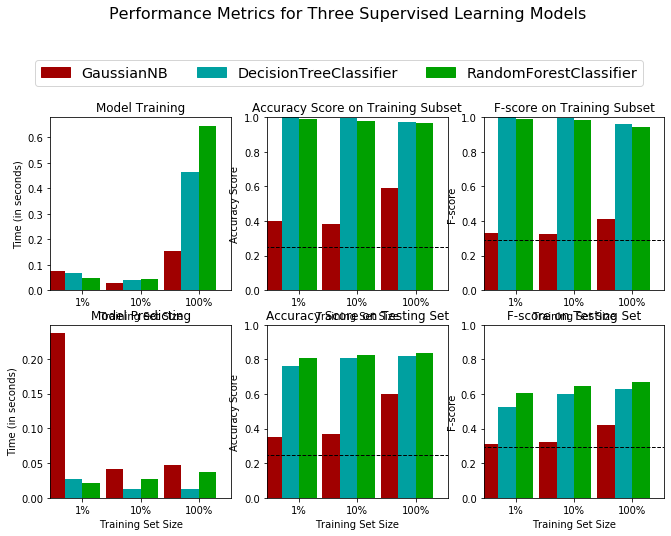

In [14]:
# Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Initialize the three models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier()
clf_C = RandomForestClassifier(random_state=23)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(len(y_train)/10)
samples_1 = int(len(y_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

### Choosing the Best Model

We will choose *Random Forest Classifier*

It has the best accuracy and F-score in testing

Training time is higher compared to the other two but it's a one time investment and less than a second - so it should be fine. Prediction time is also higher than other two, but again only by a small fraction of a second.

As mentioned before, Random Forest Classifier handles large dataset with higher dimensions well

### Describing the Model in Layman's Terms

Random forest Classifier can be explained with a real life example. Like for a job, a round of interviews are conducted and in each round, multiple questions are asked. Based on how a candidate performs as a whole in all round of interviews, he/she is selected.

A random forest classifier consists of many decision trees. A decision tree can be considered as a single round of interview, while random forest classifier can be considered as multiple round of interviews. The final decision is a combination of all decision trees.

In this particular case, questions about various parameters like marital status, capital gain will be asked and a determination will be made. Then more questions are asked on same or parameter or 

References:
http://manishbarnwal.com/blog/2016/10/18/random_forest_explained_intuitively/
https://www.youtube.com/watch?v=D_2LkhMJcfY

### Model Tuning

In [15]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = RandomForestClassifier(random_state=23)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'n_estimators':[10,20,50],'max_depth':[15,20,25],'min_samples_split':[2,5,8],'min_samples_leaf':[2,4,6]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

print(grid_fit.best_estimator_)

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

C:\Users\shahzeb.akhtar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=23, verbose=0,
                       warm_start=False)


C:\Users\shahzeb.akhtar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8383
F-score on testing data: 0.6724

Optimized Model
------
Final accuracy score on the testing data: 0.8606
Final F-score on the testing data: 0.7336


### Final Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |   0.8392          |   0.8600        |
| F-score        |   0.6753          |   0.7313        |


Optimized model's accuracy is 0.86 and F(0.5) score is 0.713. Both accuracy and F score are better than the unoptimized model. As compared to naive predictor, both accuracy and F score are way better.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

### Feature Relevance Observation

Expected Top 5 features:
1. Education-num - A highly educated individual is more likely to have an income greater than 50k, and vice versa
2. Capital-gain - An individual having capital gain, suggests, he/she owned property or investment. This makes them more like to have an income greater than 50k. The converse is true for individuals with little or no capital-gain
3. Occupation - An individual in an specialty occupation is more like to have an income of more than 50k than someone in clerical job
4. Marital-status - A married individual is more like to have a stable job, than someone who has never been married. With stable job, the chances of income greater than 50k are higher 
5. Age - An older individual, with more experience, is more like to have an income of more than 50k than someone younger with less experience.



### Extracting Feature Importance

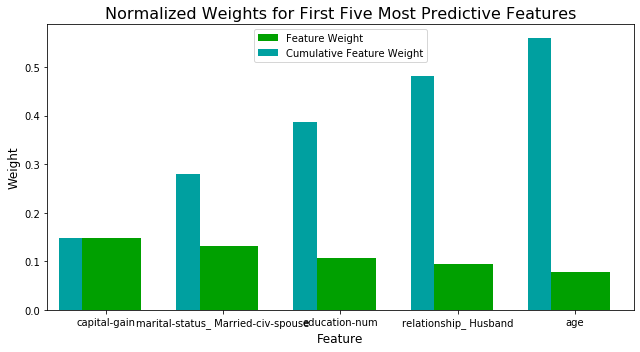

In [16]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=23, verbose=0, warm_start=False)

model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_ 

# Plot
vs.feature_plot(importances, X_train, y_train)

### Extracting Feature Importance

4 of the features that I guessed are present in extracted important features. In fact, one of the features appears twice (marital-status), due to one-hot encoding. I expected education-num to be the most important feature, but in extracted list it is at number 3. Further, I expected Occupation to be an important feature, but it is not in the extracted list.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data?

In [17]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8606
F-score on testing data: 0.7336

Final Model trained on reduced data
------
Accuracy on testing data: 0.8410
F-score on testing data: 0.6834


### Effects of Feature Selection

Accuracy is almost as good as when all features are used. F score is slightly less as compared to when all features are used.
Yes, if training time was a factor, I would consider using reduced data as training set.